In [223]:
import numpy as np
from plotnine import *
import pandas as pd

In [224]:
results = pd.read_csv("benchmark_results.csv", sep='\t')

In [225]:
nbse_info = pd.read_csv("nbse_sets.csv")

In [226]:
data = results.merge(nbse_info, left_on=['name'], right_on=['set_name'])
data['mcs_size_to_atom_size'] = data['mcs_atoms'] / data['avg_atoms']
data = data.query('local_similarity > 0 and took < 900')
data.set_index(['name', 'optimizer_steps', 'optimizer_fine', 'optimizer_coarse',
                'num_conformers', 'core', 'assemblies'])

,,,,,,,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,divide,set_name,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,avg_atoms_to_mcs,mcs_size_to_atom_size
name,optimizer_steps,optimizer_fine,optimizer_coarse,num_conformers,core,assemblies,,,,,,,,,,,,,,,,
3ke8,100,0.01,0.3,40,mcs,10,18,0.664895,0.629946,2.792387,True,3ke8,17,17,12,11,11,17,14.647,NaN,75.10%,0.751007
2vke,100,0.01,0.3,40,mcs,10,218,0.653470,0.613581,2.697748,True,2vke,42,45,31,34,22,12,33.522,NaN,65.63%,0.656285
1odn,100,0.01,0.3,40,mcs,10,303,0.569305,0.657672,3.152543,True,1odn,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
4dko,100,0.01,0.3,40,mcs,10,43,0.579109,0.458960,4.240663,True,4dko,30,33,23,24,15,13,26.077,NaN,57.52%,0.575220
3qqs,100,0.01,0.3,40,mcs,10,48,0.619915,0.311268,5.187691,True,3qqs,29,31,10,10,8,19,14.789,NaN,54.09%,0.540943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2w0v,100,0.10,0.3,20,murcko,10,215,0.386869,0.525530,7.748903,True,2w0v,39,41,17,18,9,12,28.417,NaN,31.67%,0.316712
3g5h,100,0.10,0.3,20,murcko,10,114,0.491245,0.373138,4.491310,True,3g5h,27,30,12,13,6,18,19.222,NaN,31.21%,0.312142
3id8,100,0.10,0.3,20,murcko,10,354,0.344395,0.536709,6.575580,True,3id8,37,41,19,21,9,12,29.333,NaN,30.68%,0.306822


In [227]:
data[data.name == ('1odn')]

,name,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,optimizer_coarse,optimizer_fine,num_conformers,assemblies,divide,...,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,avg_atoms_to_mcs,mcs_size_to_atom_size
2,1odn,303,0.569305,0.657672,3.152543,0.3,0.01,40,10,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
35,1odn,176,0.622042,0.482279,2.164893,0.5,0.01,10,1,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
66,1odn,269,0.500458,0.624170,2.990656,0.5,0.01,30,1,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
97,1odn,263,0.567596,0.564154,2.747688,0.5,0.01,60,1,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
129,1odn,245,0.622042,0.482279,2.164893,0.3,0.01,10,10,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
160,1odn,241,0.622042,0.482279,2.164893,0.3,0.01,20,10,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
191,1odn,261,0.622042,0.482279,2.164893,0.5,0.05,20,10,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
222,1odn,235,0.622042,0.482279,2.164893,0.5,0.10,20,10,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
253,1odn,256,0.622042,0.482279,2.164893,0.5,0.20,20,10,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531
284,1odn,138,0.530699,0.500914,2.706710,0.9,0.40,10,10,True,...,30,29,18,17,15,28,24.251,NaN,61.85%,0.618531


In [228]:
data.describe()

,took,local_similarity,avg_conformer_tanimoto_dist,siena_rmsd,optimizer_coarse,optimizer_fine,num_conformers,assemblies,optimizer_steps,most_atoms,most_bonds,least_atoms,least_bonds,mcs_atoms,num_mols,avg_atoms,mcs_bonds,mcs_size_to_atom_size
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.0,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,0.0,336.000000
mean,134.488095,0.516377,0.468676,4.108889,0.468452,0.082827,23.839286,7.482143,100.0,31.619048,34.217262,15.372024,16.044643,9.354167,17.080357,22.753000,NaN,0.412549
std,127.653635,0.096323,0.109263,1.416050,0.168094,0.118337,14.614174,4.045965,0.0,8.177004,9.178030,4.869183,5.564367,3.541167,6.129652,5.593313,NaN,0.112918
min,1.000000,0.301248,0.174775,1.647598,0.300000,0.010000,10.000000,1.000000,100.0,12.000000,12.000000,9.000000,9.000000,4.000000,12.000000,10.769000,NaN,0.298533
25%,42.750000,0.448015,0.387418,2.903391,0.300000,0.010000,10.000000,1.000000,100.0,26.750000,29.000000,11.000000,11.000000,7.000000,13.000000,19.210500,NaN,0.318590
50%,101.000000,0.520535,0.481296,3.842649,0.500000,0.010000,20.000000,10.000000,100.0,30.000000,32.000000,14.000000,15.000000,9.000000,15.000000,21.560000,NaN,0.375834
75%,187.250000,0.587124,0.538222,5.195686,0.500000,0.100000,30.000000,10.000000,100.0,37.000000,41.000000,18.000000,20.000000,11.000000,19.000000,26.077000,NaN,0.475160
max,879.000000,0.719335,0.737755,8.482188,0.900000,0.400000,60.000000,10.000000,100.0,73.000000,80.000000,31.000000,34.000000,22.000000,40.000000,37.294000,NaN,0.751007


In [229]:
metric_cols = ['siena_rmsd', 'avg_conformer_tanimoto_dist',
               'local_similarity']

program_parameters = ['assemblies', 'num_conformers', 'optimizer_coarse',
                      'optimizer_fine', 'optimizer_steps']

set_props = [str(c) for c in nbse_info.columns] + ['mcs_size_to_atom_size']

def lookup_en_name(s: str) -> str:
    name_lookup_en = {
        'name': 'Name',
        'took': 'Runtime',
        'siena_rmsd': 'SIENA RMSD',
        'avg_conformer_tanimoto_dist': 'Conformer Score',
        'local_similarity': 'Local Similarity',
        'most_atoms': 'Most Atoms',
        'least_atoms': 'Least Atoms',
        'most_bonds': 'Most Bonds',
        'least_bonds': 'Least Bonds',
        'num_mols': 'No. Molecules',
        'avg_atoms': 'Avg. Atoms',
        'mcs_atoms': 'Size MCS',
        'mcs_size_to_atom_size': 'Size MCS / Avg. Atoms',
        'optimizer_coarse': 'Optimizer Coarse',
        'optimizer_fine': 'Optimizer Fine',
        'optimizer_steps': 'Optimizer Steps',
        'num_conformers': 'No. Conformers',
        'assemblies': 'Assemblies'
    }

    if s in name_lookup_en:
        return name_lookup_en[s]
    else:
        return s

def lookup_de_name(s: str) -> str:
    return lookup_en_name(s)
    # name_lookup_de = {
    #     'name': 'Name',
    #     'took': 'Laufzeit',
    #     'siena_rmsd': 'SIENA RMSD',
    #     'avg_conformer_tanimoto_dist': 'Konformer Distanz',
    #     'local_similarity': 'Lokale Ähnlichkeit',
    #     'most_atoms': 'Meiste Atome',
    #     'least_atoms': 'Kleinste Atome',
    #     'most_bonds': 'Meiste Bindungen',
    #     'least_bonds': 'Wenigste Bindungen',
    #     'num_mols': 'Menge Moleküle',
    #     'avg_atoms': 'Durschn. Atome',
    #     'mcs_atoms': 'Größe MCS',
    #     'mcs_size_to_atom_size': 'MCS / Durchschn. Atome',
    #     'optimizer_coarse': 'Optimizer Coarse',
    #     'optimizer_fine': 'Optimizer Fine',
    #     'optimizer_steps': 'Optimizer Steps',
    #     'num_conformers': 'Konformere',
    #     'assemblies': 'Assemblies'
    # }
    # 
    # if s in name_lookup_de:
    #     return name_lookup_de[s]
    # else:
    #     return s


In [230]:
metrics = data.drop(columns=['set_name', 'name', 'divide', 'core', 'mcs_bonds',
                             'avg_atoms_to_mcs'])
metrics.var()

took                           16295.450604
local_similarity                   0.009278
avg_conformer_tanimoto_dist        0.011938
siena_rmsd                         2.005198
optimizer_coarse                   0.028256
optimizer_fine                     0.014004
num_conformers                   213.574094
assemblies                        16.369829
optimizer_steps                    0.000000
most_atoms                        66.863397
most_bonds                        84.236238
least_atoms                       23.708946
least_bonds                       30.962180
mcs_atoms                         12.539863
num_mols                          37.572628
avg_atoms                         31.285154
mcs_size_to_atom_size              0.012751
dtype: float64

In [231]:
data.groupby(program_parameters).agg({ k: 'mean' for k in metrics})

took  \
assemblies num_conformers optimizer_coarse optimizer_fine optimizer_steps               
1          10             0.5              0.01           100              103.870968   
           30             0.5              0.01           100              110.870968   
           60             0.5              0.01           100              113.875000   
10         10             0.3              0.01           100              146.419355   
                          0.9              0.40           100              105.031250   
           20             0.3              0.01           100              136.225806   
                                           0.10           100              277.173913   
                          0.5              0.05           100              121.548387   
                                           0.10           100              117.322581   
                                           0.20           100              118.741935   
           40             0.3              0.01           100              165.718750   

                                                                           local_similarity  \
assemblies num_conformers optimizer_coarse optimizer_fine optimizer_steps                     
1          10             0.5              0.01           100                      0.508145   
           30             0.5              0.01           100                      0.512818   
           60             0.5              0.01           100                      0.524790   
10         10             0.3              0.01           100                      0.519407   
                          0.9              0.40           100                      0.493847   
           20             0.3              0.01           100                      0.520859   
                                           0.10           100                      0.527046   
                          0.5              0.05           100                      0.519035   
                                           0.10           100                      0.519035   
                                           0.20           100                      0.519035   
           40             0.3              0.01           100                      0.519241   

                                                                           avg_conformer_tanimoto_dist  \
assemblies num_conformers optimizer_coarse optimizer_fine optimizer_steps                                
1          10             0.5              0.01           100                                 0.468015   
           30             0.5              0.01           100                                 0.475280   
           60             0.5              0.01           100                                 0.458919   
10         10             0.3              0.01           100                                 0.462496   
                          0.9              0.40           100                                 0.465492   
           20             0.3              0.01           100                                 0.470823   
                                           0.10           100                                 0.462090   
                          0.5              0.05           100                                 0.469914   
                                           0.10           100                                 0.469914   
                                           0.20           100                                 0.469914   
           40             0.3              0.01           100                                 0.480903   

                                                                           siena_rmsd  \
assemblies num_conformers optimizer_coarse optimizer_fine optimizer_steps               
1          10             0.5              0.01           100                4.146476   
           30             0.5            

In [232]:
metrics.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
took,336.0,134.488095,127.653635,1.000000,42.750000,101.000000,187.250000,879.000000
local_similarity,336.0,0.516377,0.096323,0.301248,0.448015,0.520535,0.587124,0.719335
avg_conformer_tanimoto_dist,336.0,0.468676,0.109263,0.174775,0.387418,0.481296,0.538222,0.737755
siena_rmsd,336.0,4.108889,1.416050,1.647598,2.903391,3.842649,5.195686,8.482188
optimizer_coarse,336.0,0.468452,0.168094,0.300000,0.300000,0.500000,0.500000,0.900000
optimizer_fine,336.0,0.082827,0.118337,0.010000,0.010000,0.010000,0.100000,0.400000
num_conformers,336.0,23.839286,14.614174,10.000000,10.000000,20.000000,30.000000,60.000000
assemblies,336.0,7.482143,4.045965,1.000000,1.000000,10.000000,10.000000,10.000000
optimizer_steps,336.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
most_atoms,336.0,31.619048,8.177004,12.000000,26.750000,30.000000,37.000000,73.000000


In [233]:
correlation = 'pearson'
correlations = metrics.corr(method=correlation)
correlation = correlation.capitalize()

In [234]:
corr = correlations.stack().reset_index()
corr.columns = ['var1', 'var2', 'val']
corr_config = corr.loc[corr['var2'].isin(metric_cols)]
corr_config = corr_config.loc[corr['var1'].isin(set_props)]
corr_config = corr_config.round({'val': 3})

corr_config['var1'] = corr_config['var1'].map(lookup_en_name)
corr_config['var2'] = corr_config['var2'].map(lookup_en_name)


In [235]:
corr

,var1,var2,val
0,took,took,1.000000
1,took,local_similarity,-0.262456
2,took,avg_conformer_tanimoto_dist,0.017811
3,took,siena_rmsd,0.233797
4,took,optimizer_coarse,-0.183356
...,...,...,...
251,mcs_size_to_atom_size,least_bonds,0.179005
252,mcs_size_to_atom_size,mcs_atoms,0.677782
253,mcs_size_to_atom_size,num_mols,-0.061275
254,mcs_size_to_atom_size,avg_atoms,-0.051723


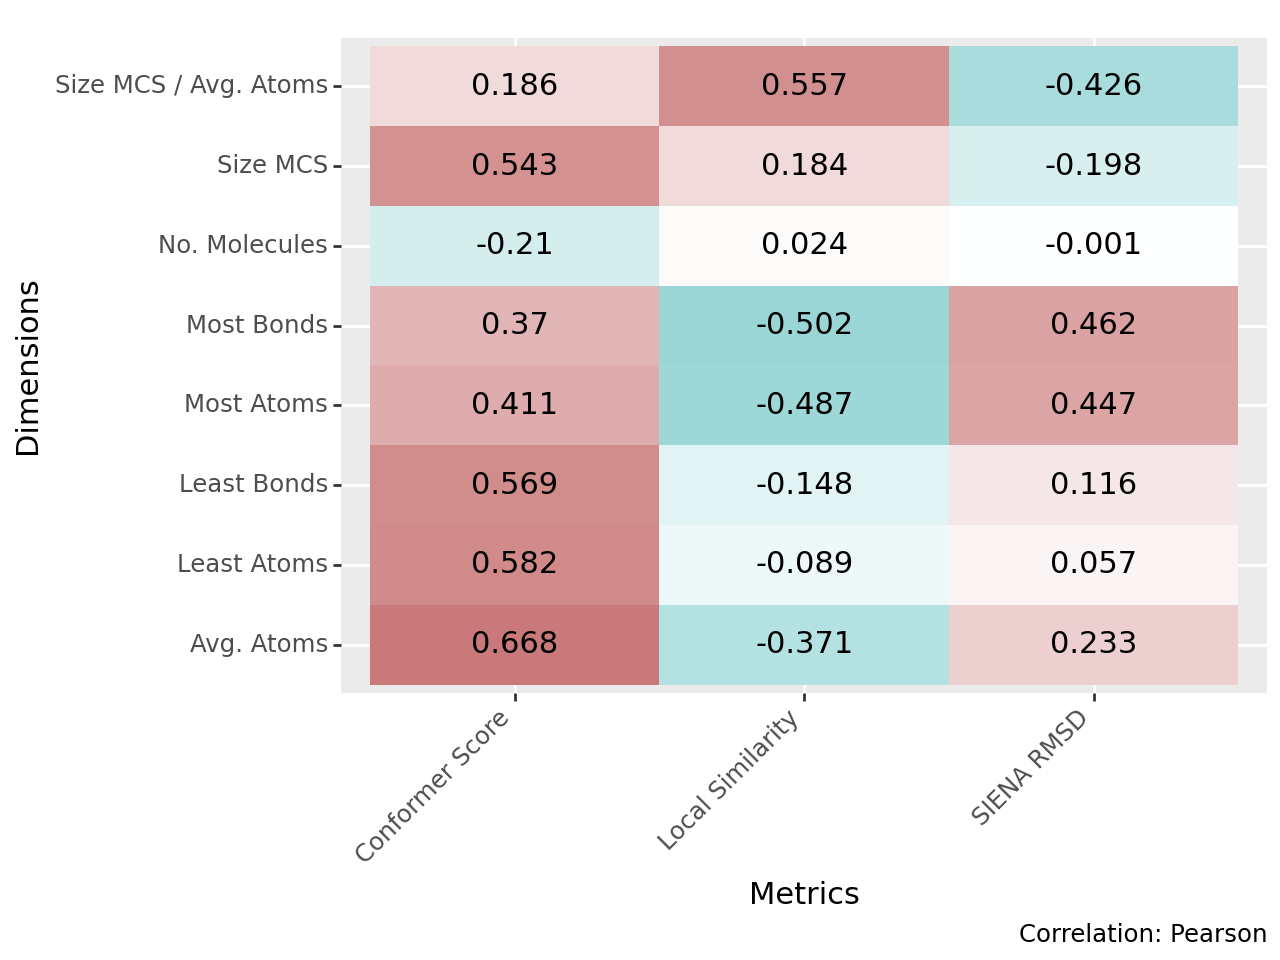

<Figure Size: (640 x 480)>

In [236]:
(ggplot(corr_config, mapping=aes('var2', 'var1', fill='val', label='val'))
 + geom_tile()
 + scale_fill_gradient2(low='#79c9c9', high='#C97979', guide=False)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + geom_text()
 + labs(x='Metrics', y='Dimensions', caption='Correlation: {}'.format(correlation))
 )

In [237]:
corr_metrics = corr[
    corr['var1'].isin(metric_cols) & corr['var2'].isin(metric_cols)]
corr_metrics = corr_metrics.round({'val': 3})

corr_metrics['var1'] = corr_metrics['var1'].map(lookup_en_name)
corr_metrics['var2'] = corr_metrics['var2'].map(lookup_en_name)


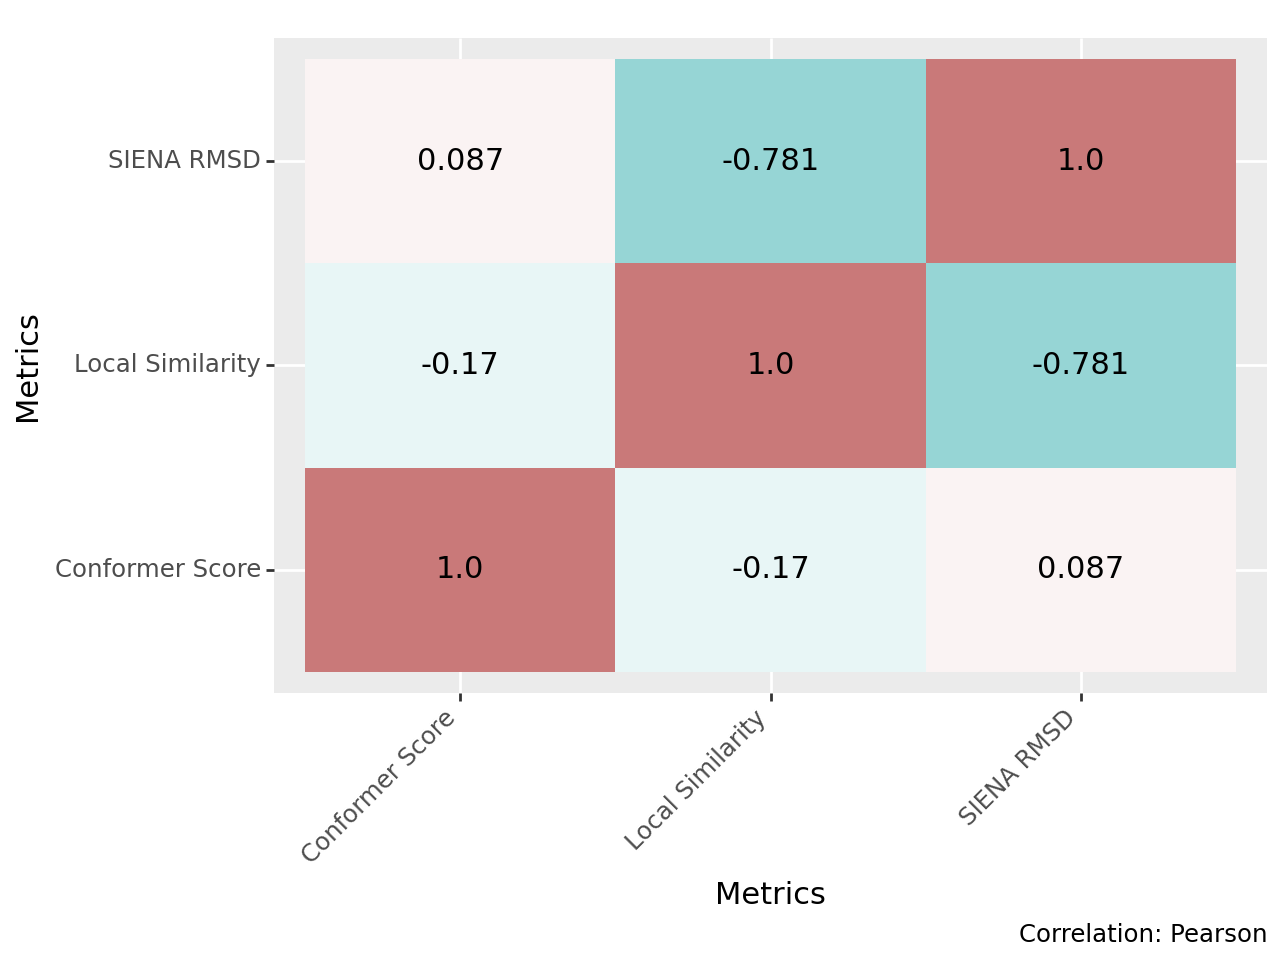

<Figure Size: (640 x 480)>

In [238]:
(ggplot(corr_metrics, mapping=aes('var1', 'var2', fill='val', label='val'))
 + geom_tile()
 + scale_fill_gradient2(low='#79c9c9', high='#C97979', guide=False)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + geom_text()
 + labs(x='Metrics', y='Metrics', caption='Correlation: {}'.format(correlation))
 )

In [239]:
corr_options = corr[
    corr['var1'].isin(program_parameters) & corr['var2'].isin(metric_cols)]
corr_options = corr_options.round({'val': 3})
corr_options['var1'] = corr_options['var1'].map(lookup_de_name)
corr_options['var2'] = corr_options['var2'].map(lookup_de_name)


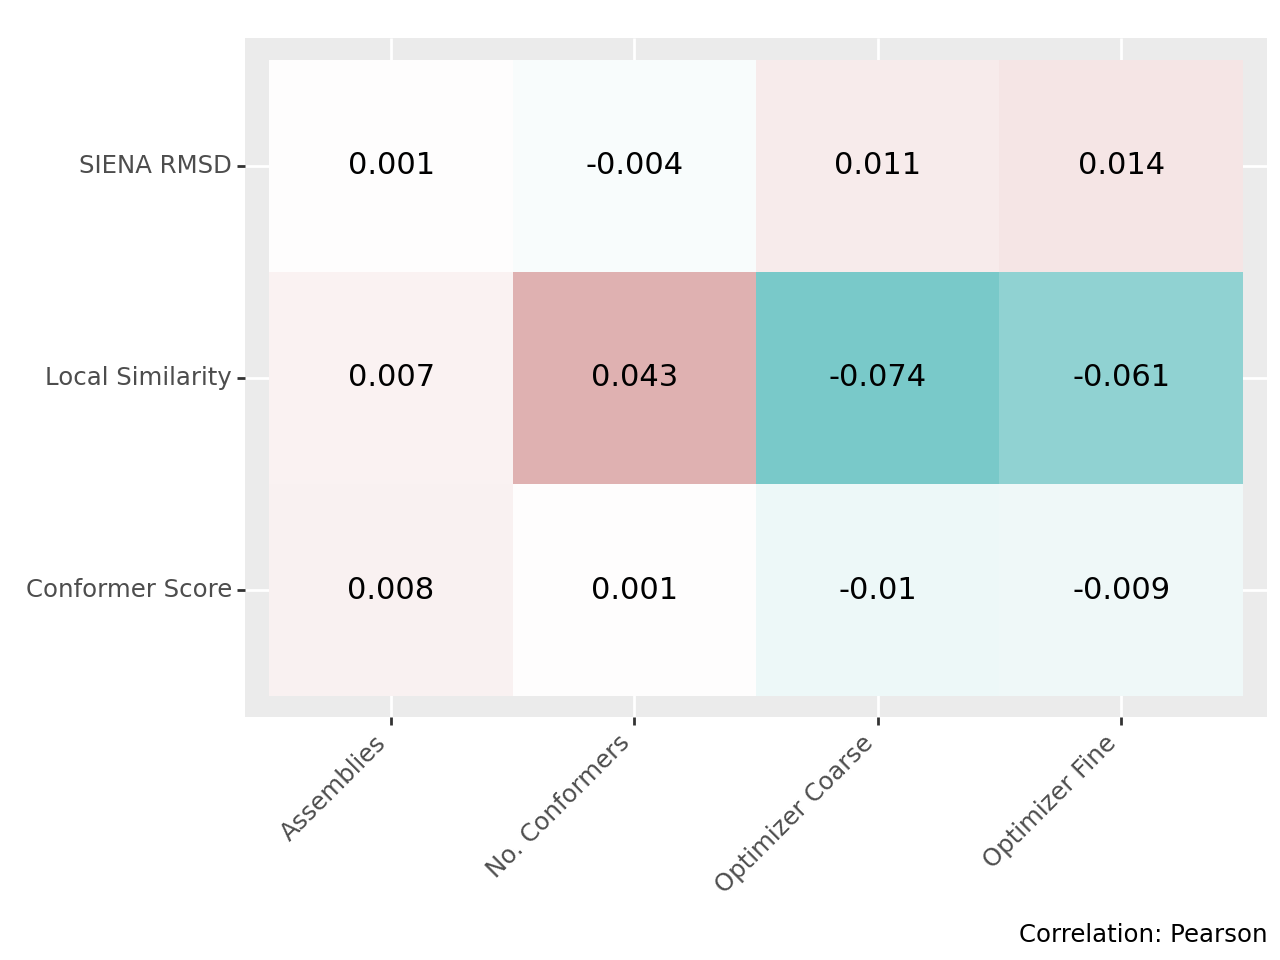

<Figure Size: (640 x 480)>

In [240]:
(ggplot(corr_options, mapping=aes('var1', 'var2', fill='val', label='val'))
 + geom_tile()
 + scale_fill_gradient2(low='#79c9c9', high='#C97979', guide=False)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + geom_text()
 + labs(x='', y='',caption='Correlation: {}'.format(correlation))
 )


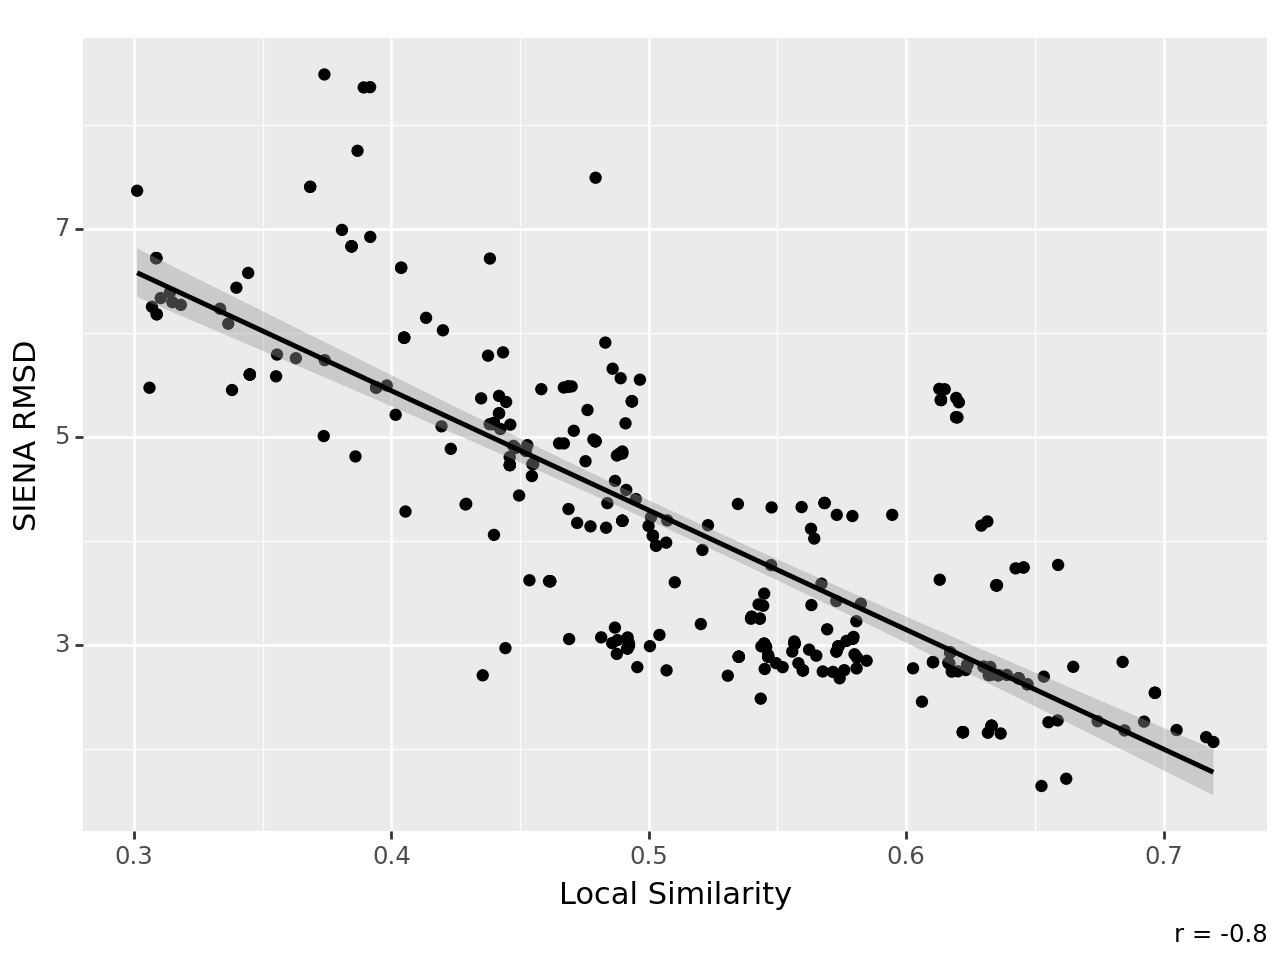

<Figure Size: (640 x 480)>

In [241]:
(ggplot(data=data, mapping=aes(x='local_similarity', y='siena_rmsd'))
 + geom_point()
 + geom_smooth(method='lm')
 + labs(x=lookup_de_name('local_similarity'), y=lookup_de_name('siena_rmsd'), caption='r = -0.8')
 )

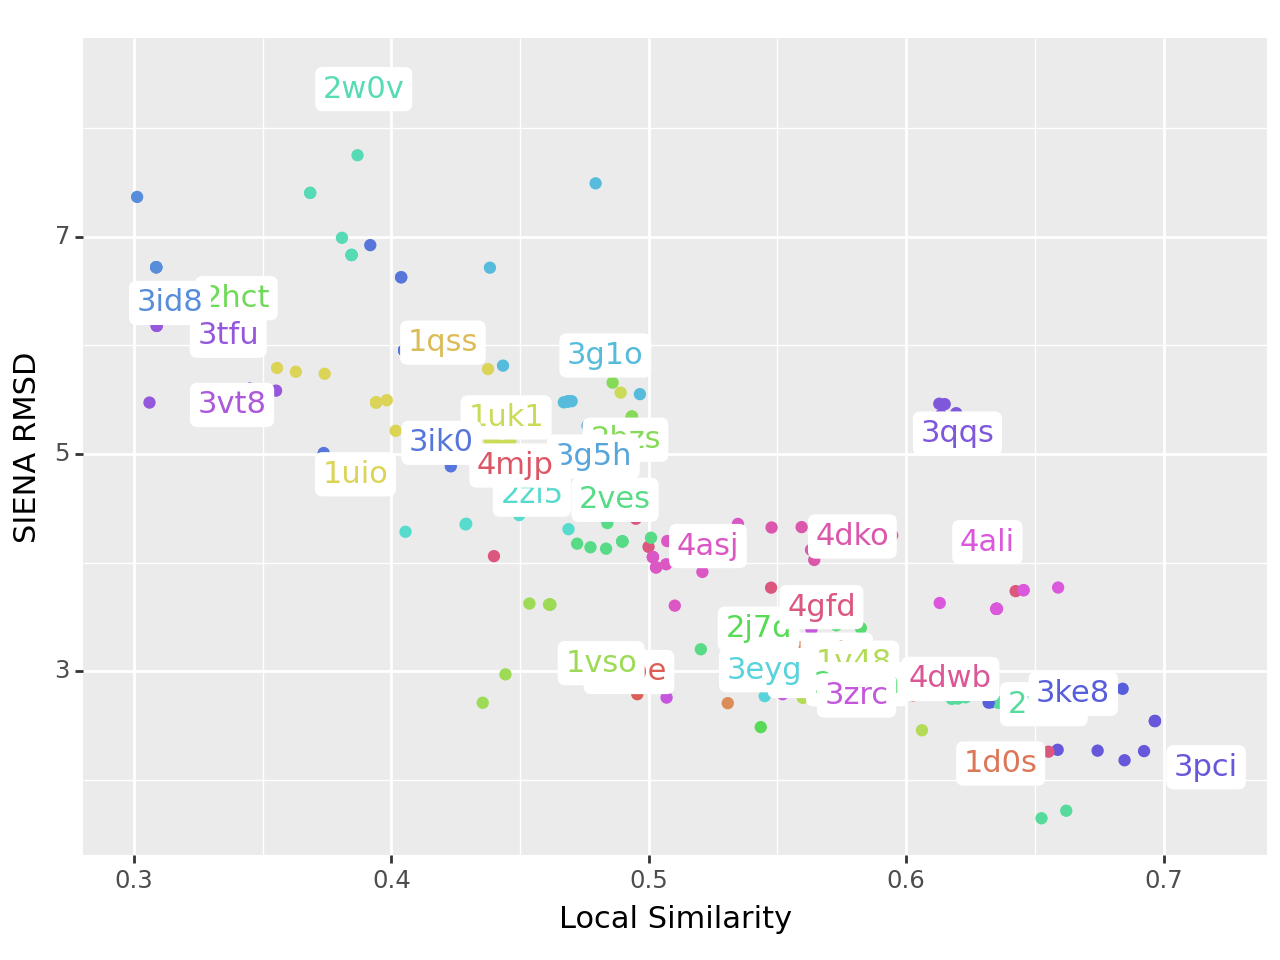

<Figure Size: (640 x 480)>

In [242]:
(ggplot(data=data,
        mapping=aes(x='local_similarity', y='siena_rmsd', colour='name',
                    label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_en_name('local_similarity'), y=lookup_en_name('siena_rmsd'))
 )


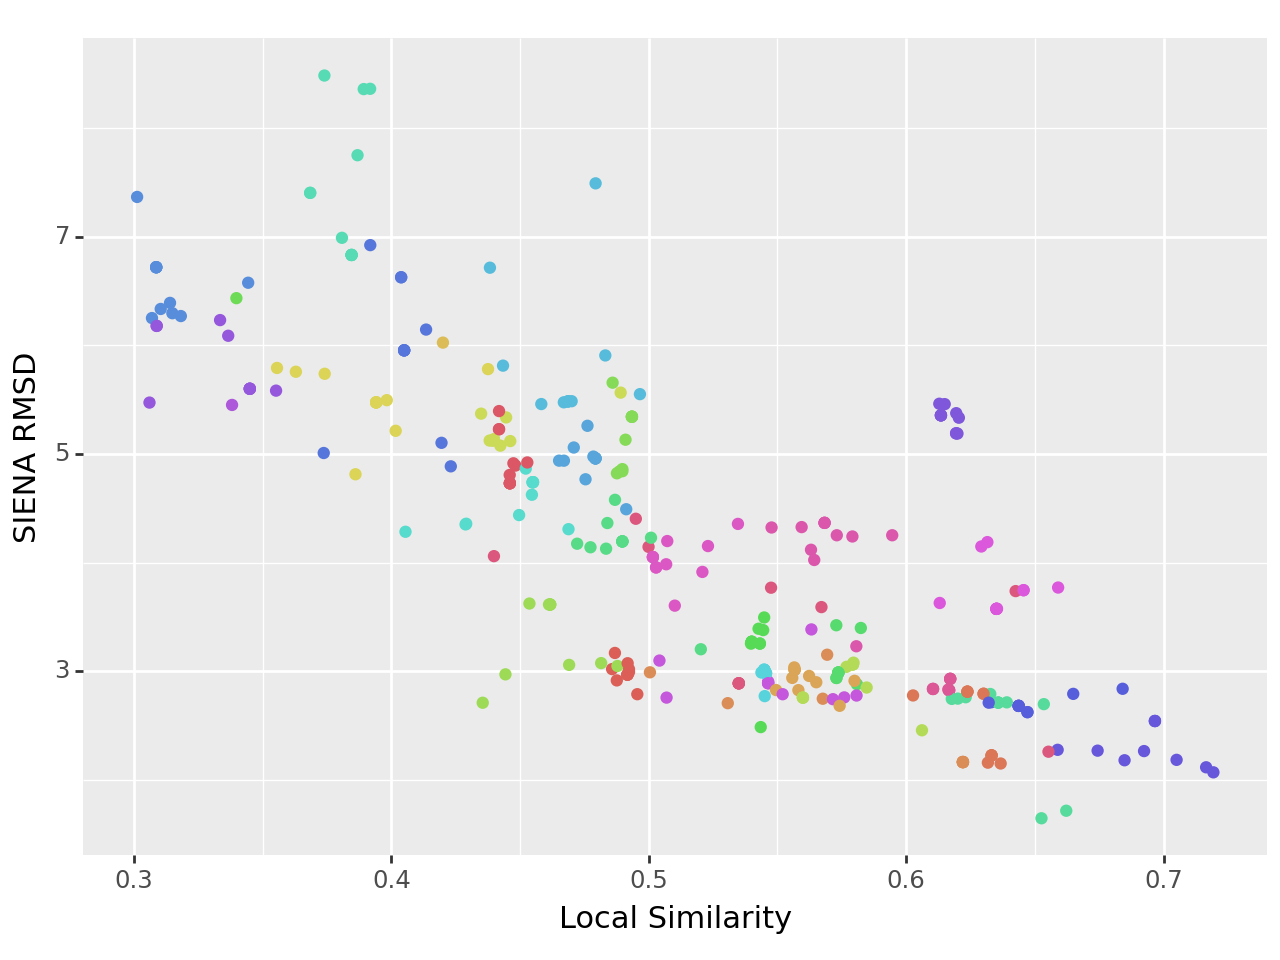

<Figure Size: (640 x 480)>

In [243]:
(ggplot(data=data, mapping=aes(x='local_similarity', y='siena_rmsd', colour='name',
                    label='name'))
 + geom_point()
 + geom_label(data=data.loc[data['name'] == '4ajn'].groupby('name').first().reset_index(), boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_de_name('local_similarity'), y=lookup_de_name('siena_rmsd'))
 )



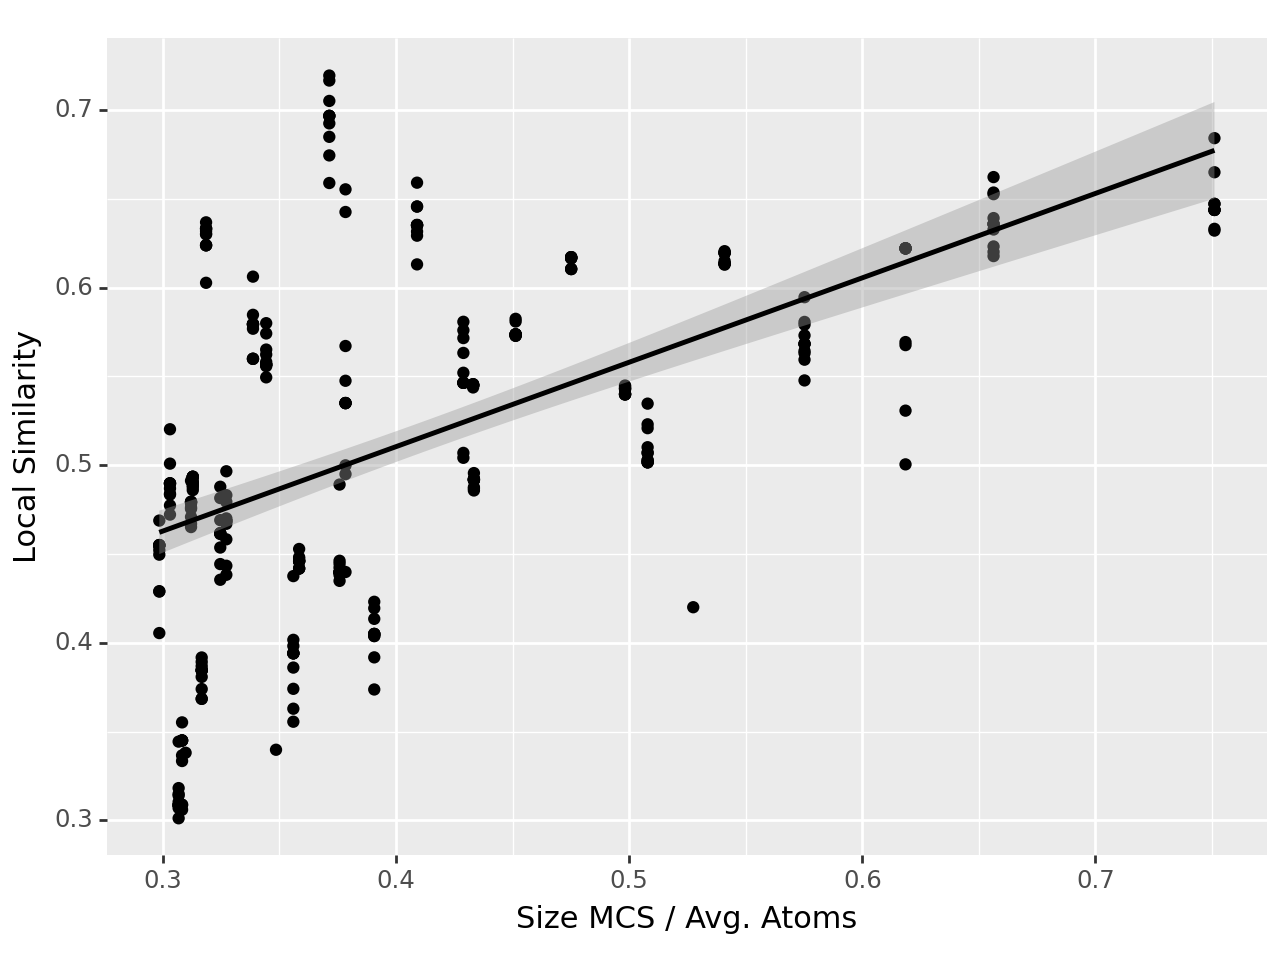

<Figure Size: (640 x 480)>

In [244]:
(ggplot(data=data, mapping=aes(x='mcs_size_to_atom_size', y='local_similarity'))
 + geom_point()
 + geom_smooth(method='lm')
 + labs(x=lookup_de_name('mcs_size_to_atom_size'), y=lookup_de_name('local_similarity'))
 )

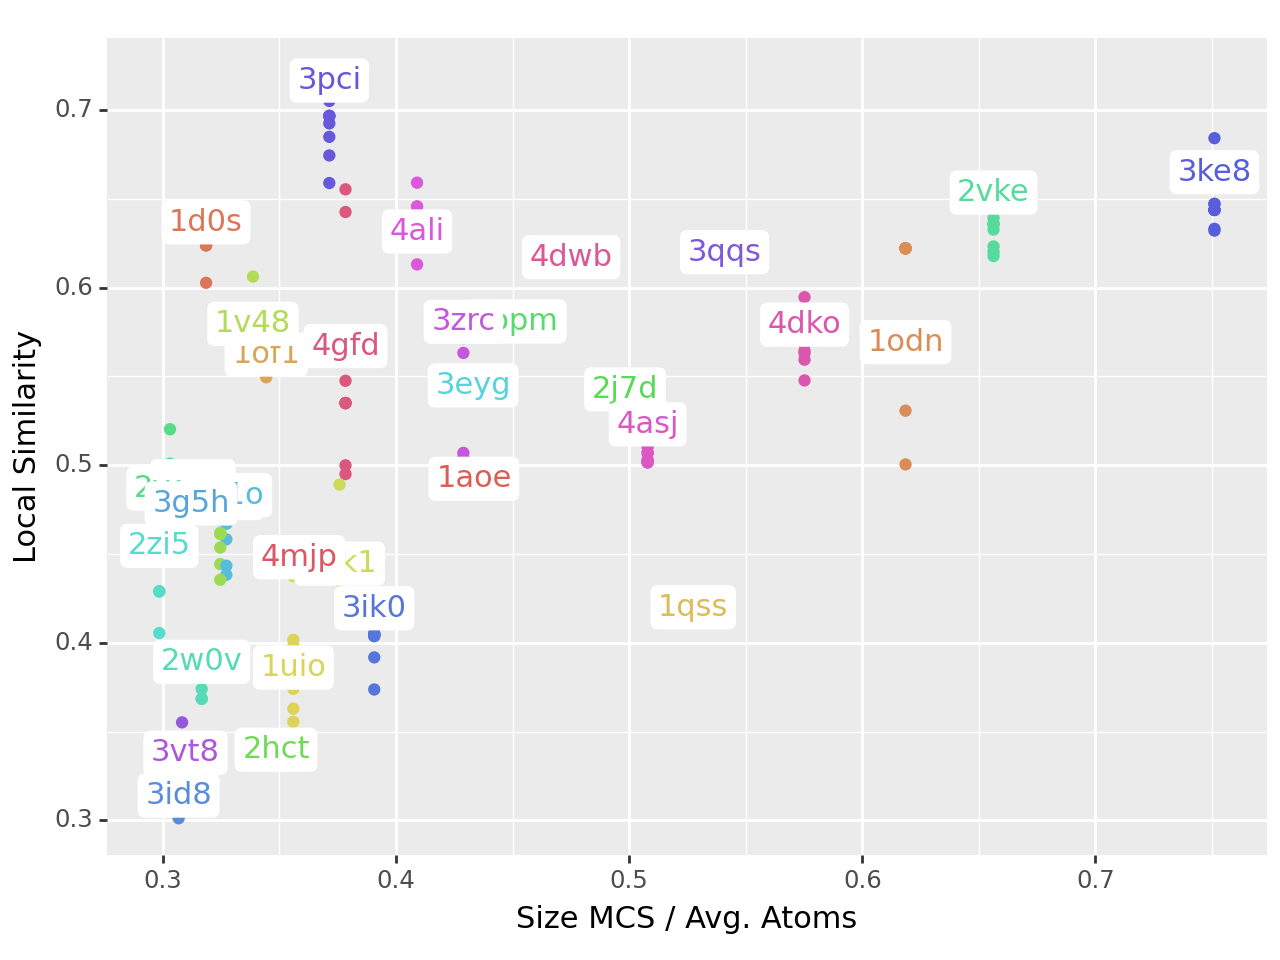

<Figure Size: (640 x 480)>

In [245]:
(ggplot(data=data, mapping=aes(x='mcs_size_to_atom_size', y='local_similarity',
                               colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(), boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_de_name('mcs_size_to_atom_size'), y=lookup_de_name('local_similarity'))
 )


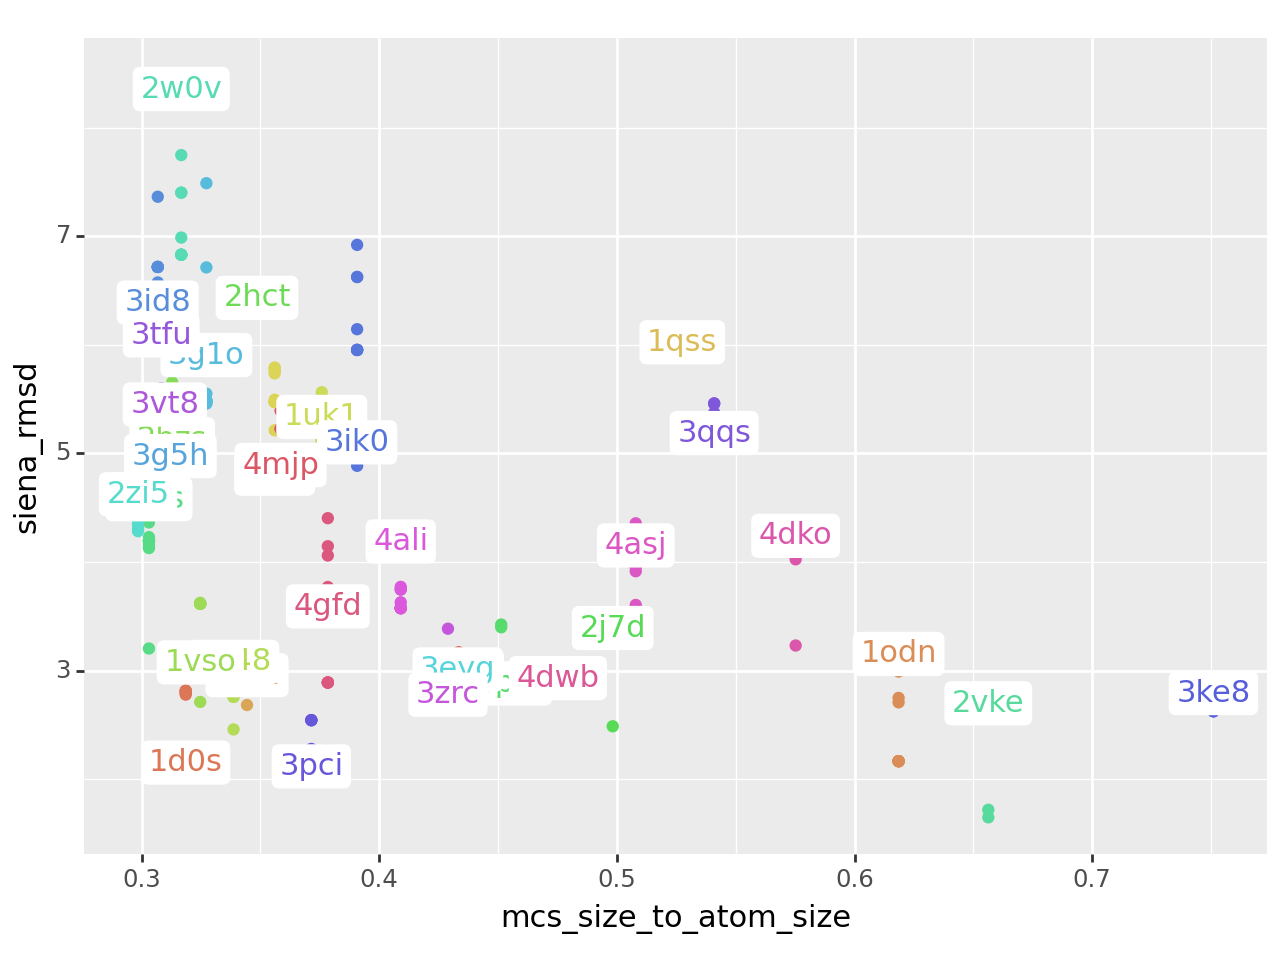

<Figure Size: (640 x 480)>

In [246]:
(ggplot(data=data,
        mapping=aes(x='mcs_size_to_atom_size', y='siena_rmsd', colour='name',
                    label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )


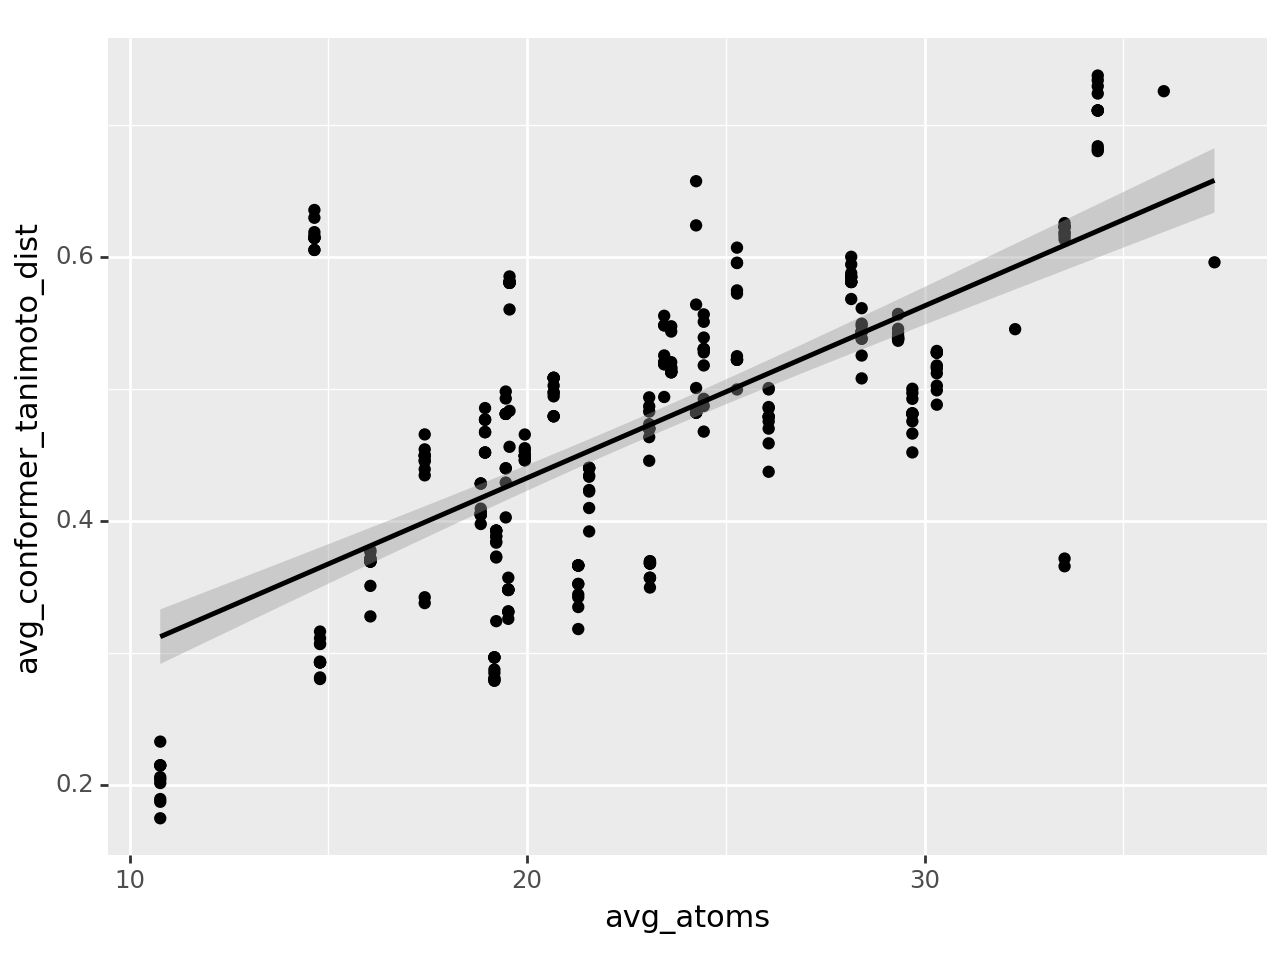

<Figure Size: (640 x 480)>

In [247]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='avg_conformer_tanimoto_dist'))
 + geom_point()
 + geom_smooth(method='lm'))

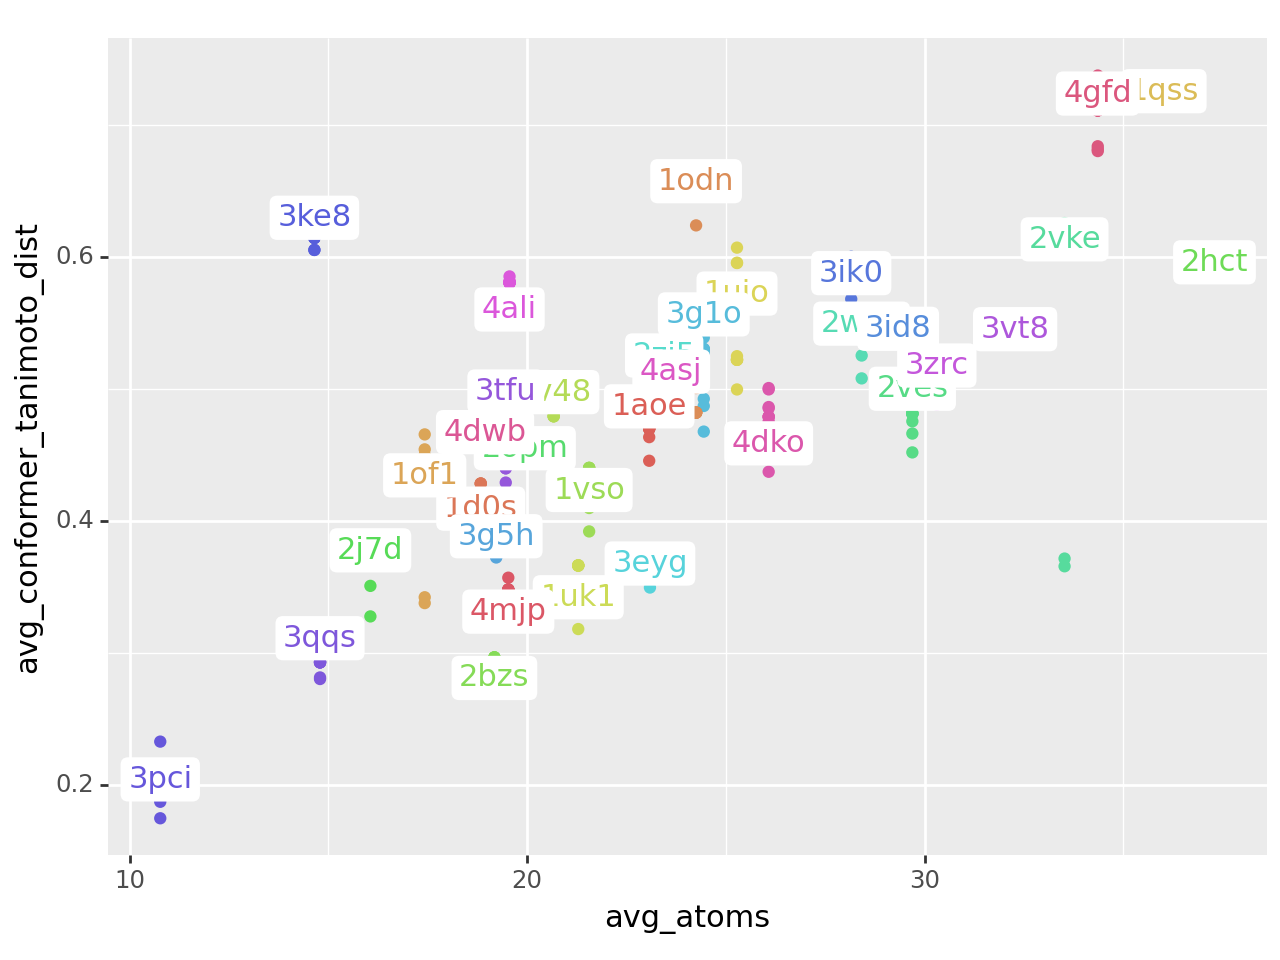

<Figure Size: (640 x 480)>

In [248]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='avg_conformer_tanimoto_dist',
                               colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )


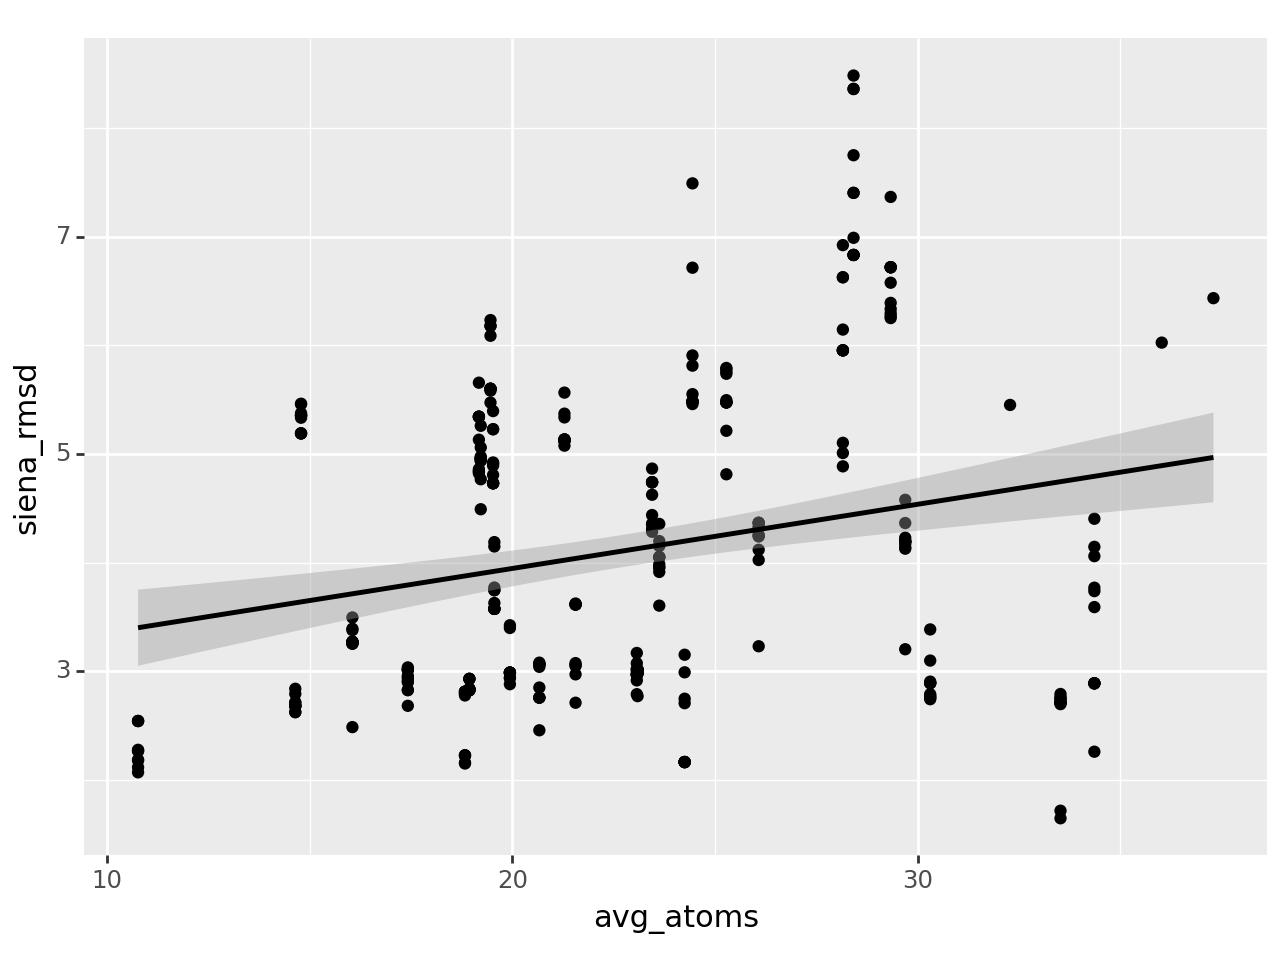

<Figure Size: (640 x 480)>

In [249]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='siena_rmsd'))
 + geom_point()
 + geom_smooth(method='lm'))

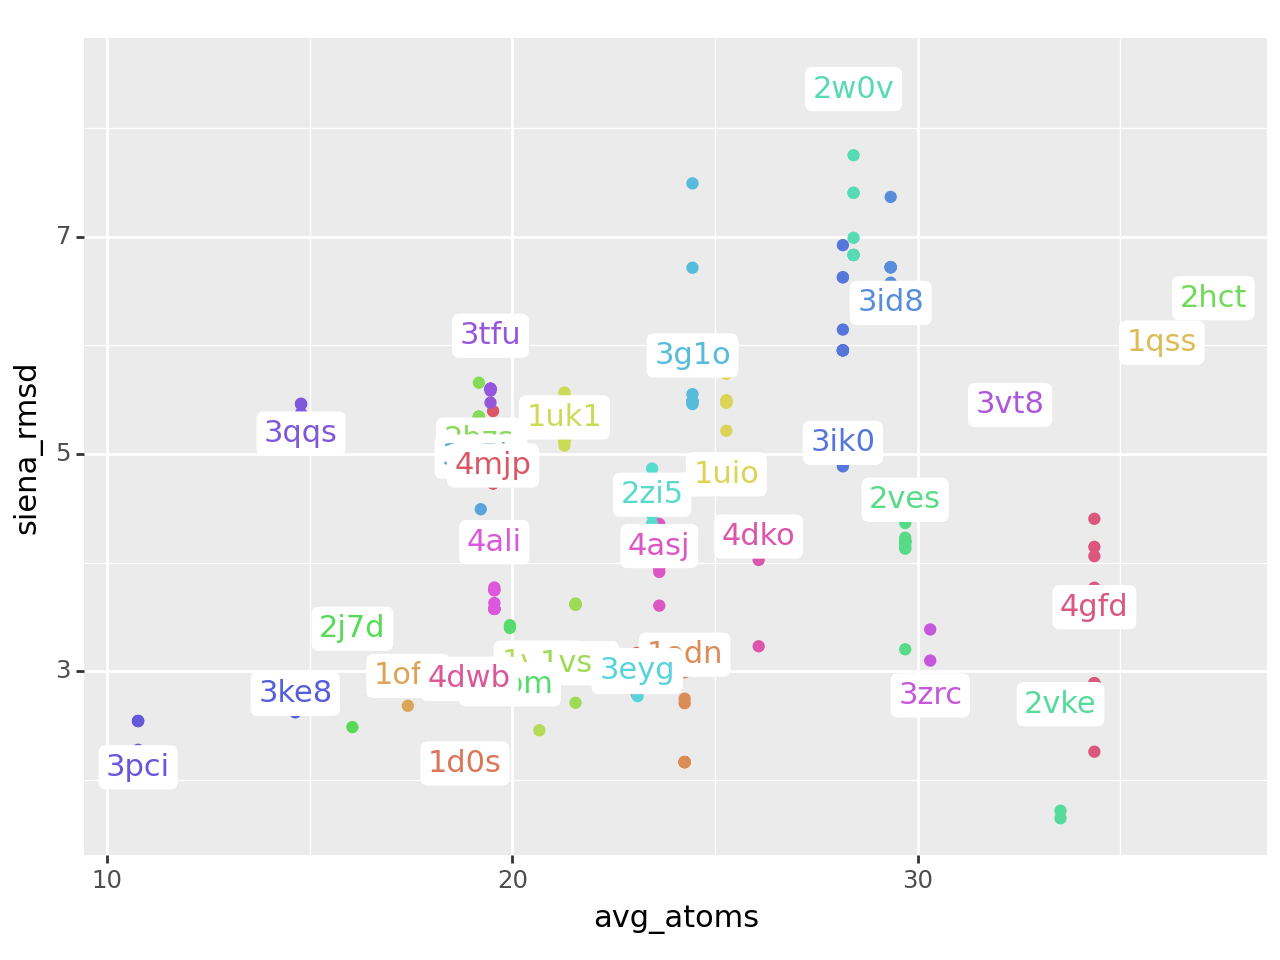

<Figure Size: (640 x 480)>

In [250]:
(ggplot(data=data,
        mapping=aes(x='avg_atoms', y='siena_rmsd', colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )


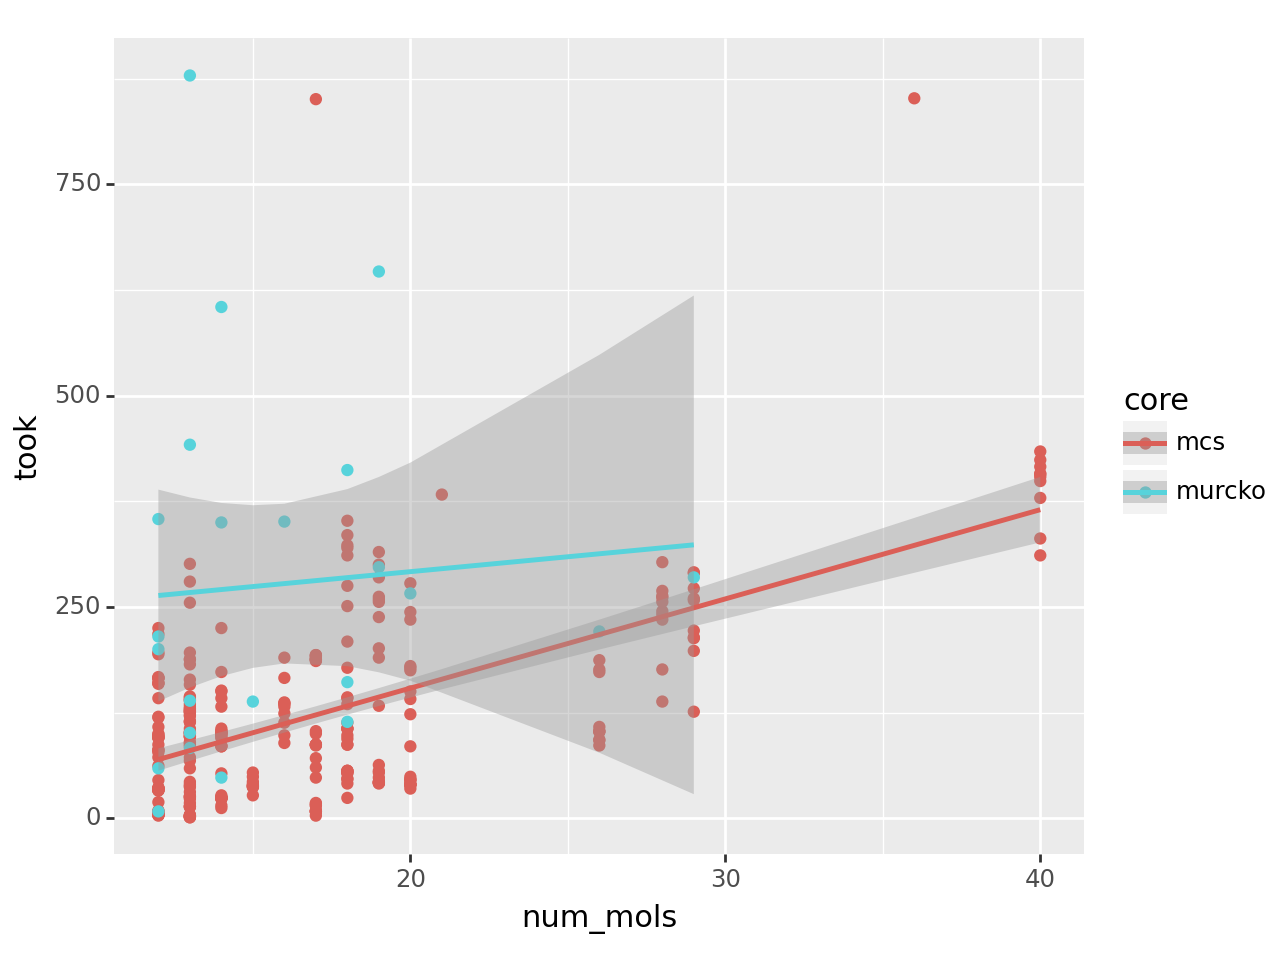

<Figure Size: (640 x 480)>

In [251]:
(ggplot(data=data, mapping=aes(x='num_mols', y='took', colour='core'))
 + geom_point()
 + geom_smooth(method='lm'))

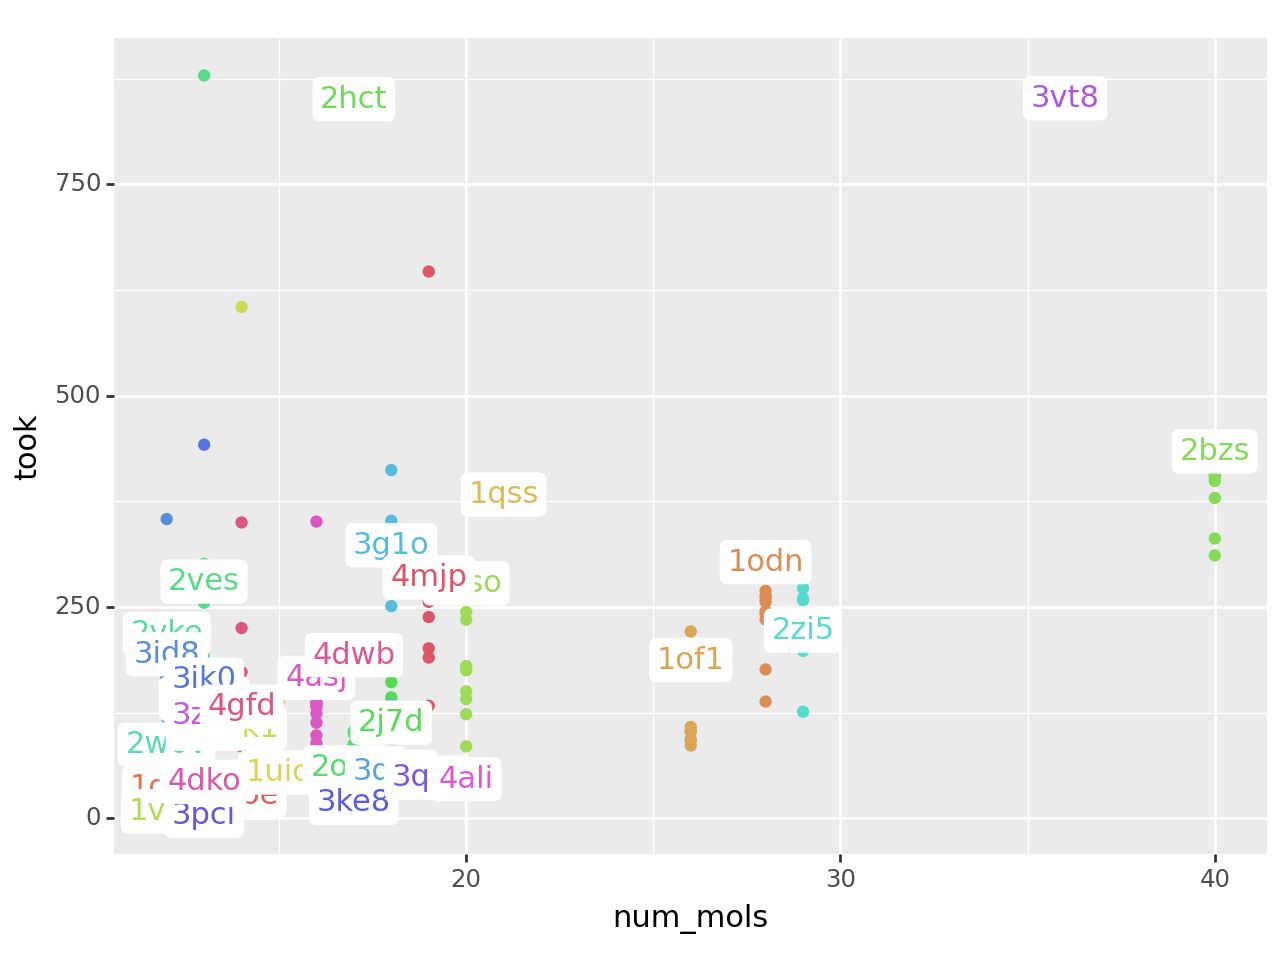

<Figure Size: (640 x 480)>

In [252]:
(ggplot(data=data,
        mapping=aes(x='num_mols', y='took', colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )